In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import numpy as np 
import scipy.stats 


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

import pandas as pd
import numpy as np 
import random 
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import re

import seaborn as sns
import matplotlib.pyplot as plt
import re

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=False, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
        "#89DAFF", # Pale azure
        "#00A896", # Persian green,
        "#D41876", # Telemagenta
        "#F7B2AD", # Melon
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta

        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)
    return hex_color_list

def clean_vars(s, how='title'):
    """
    Simple function to clean titles

    Params
    - s: The string to clean
    - how (default='title'): How to return string. Can be either ['title', 'lowercase', 'uppercase']

    Returns
    - cleaned string
    """
    assert how in ['title', 'lowercase', 'uppercase'], "Bad option!! see docs"
    s = re.sub('([a-z0-9])([A-Z])', r'\1 \2', s)
    s = s.replace('_', ' ')
    if how == 'title':
        return s.title()
    elif how=='lower':
        return s.lower()
    elif how=='upper':
    	return s.upper()
    
mypal = make_aesthetic()
random.seed(42)
np.random.seed(42)

# Read in data

In [2]:
df = pd.read_csv("all_pw_data_enriched.csv")
df['window_str'] = df['in_window'].apply(lambda x: "Inside Model Window" if x==1 else "Outside Model Window")
sample = df.groupby(by=['model', 'category']).sample(50000, random_state=42)
sample.to_csv("all_pw_data_enriched_sample_300K.csv")

## Simple analysis (dist in window)

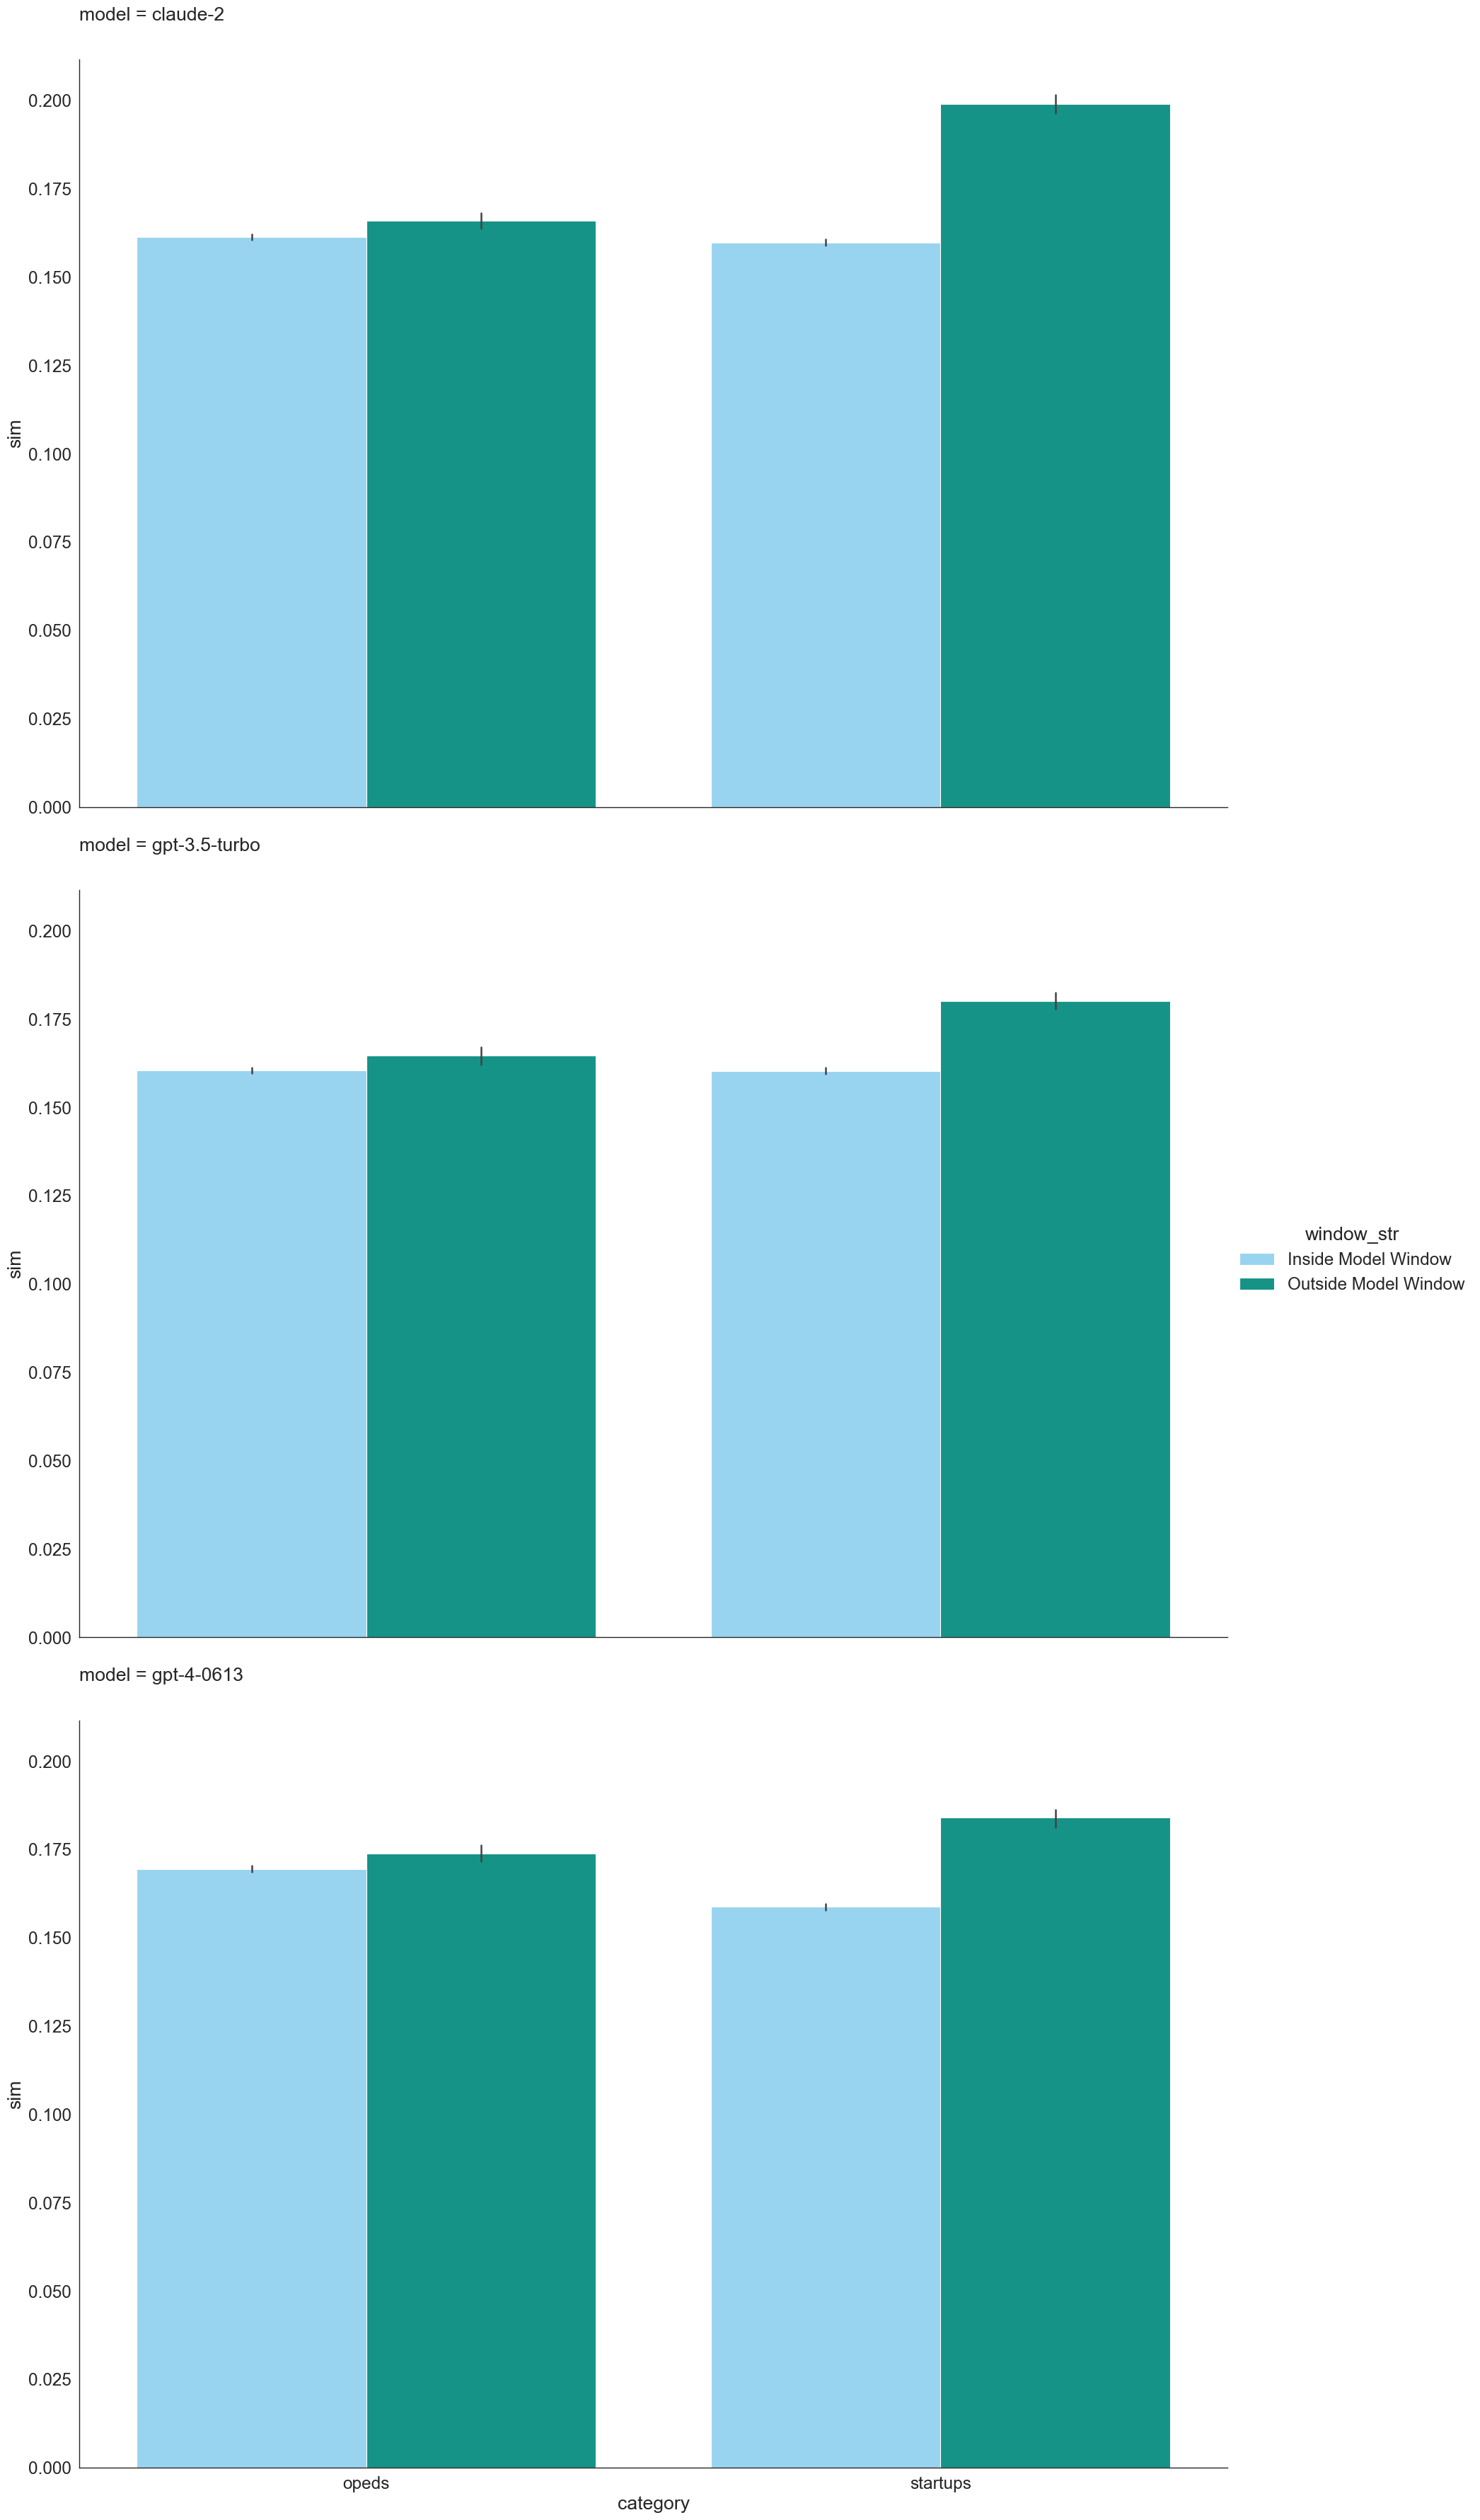

In [3]:
sns.catplot(data=sample, 
            kind='bar',
            hue='window_str', 
            y='sim', 
            x='category',
            row='model', 
            height=12, 
            aspect = 12/8
    )

# Idea-Level: 

- Foreach AI idea, plot the mean, median, 75th, max sim for in vs outside of window

In [44]:
sample2 = sample.groupby(by=['ai_id', 'model', 'category', 'window_str'])['sim'].agg(
    mean='mean',
    median='median',
    max='max',
    percentile_75=lambda x: np.percentile(x, 75)
).reset_index()

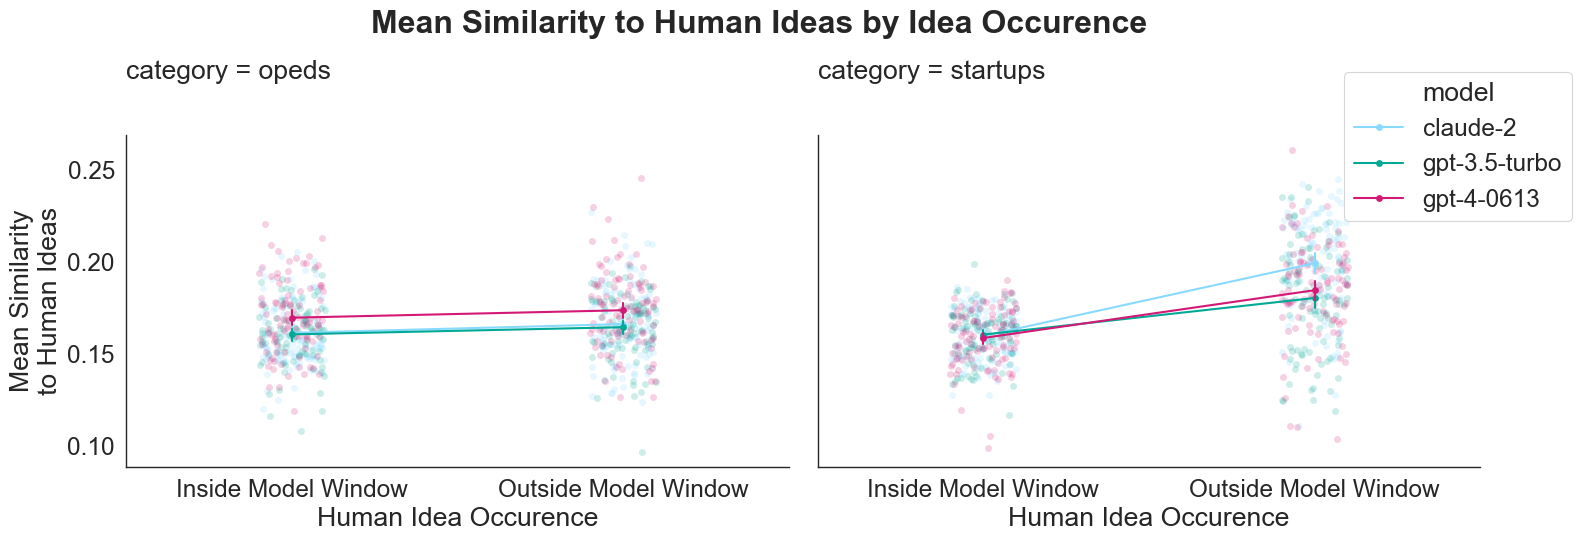

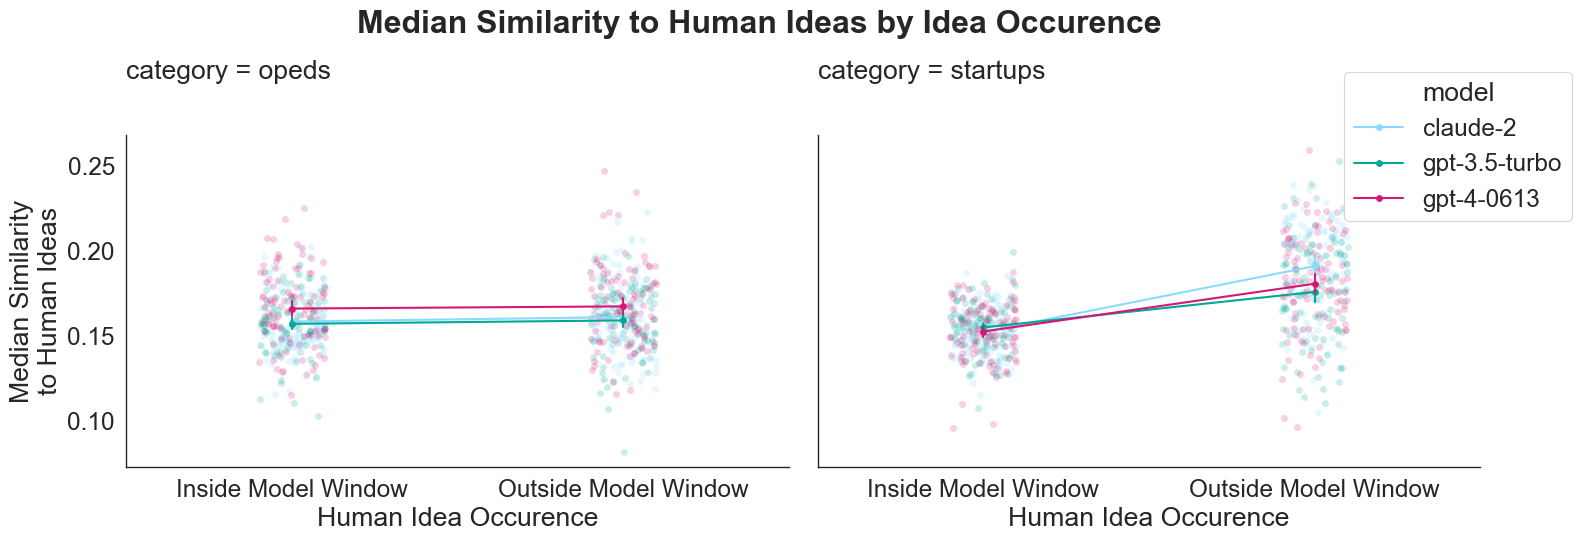

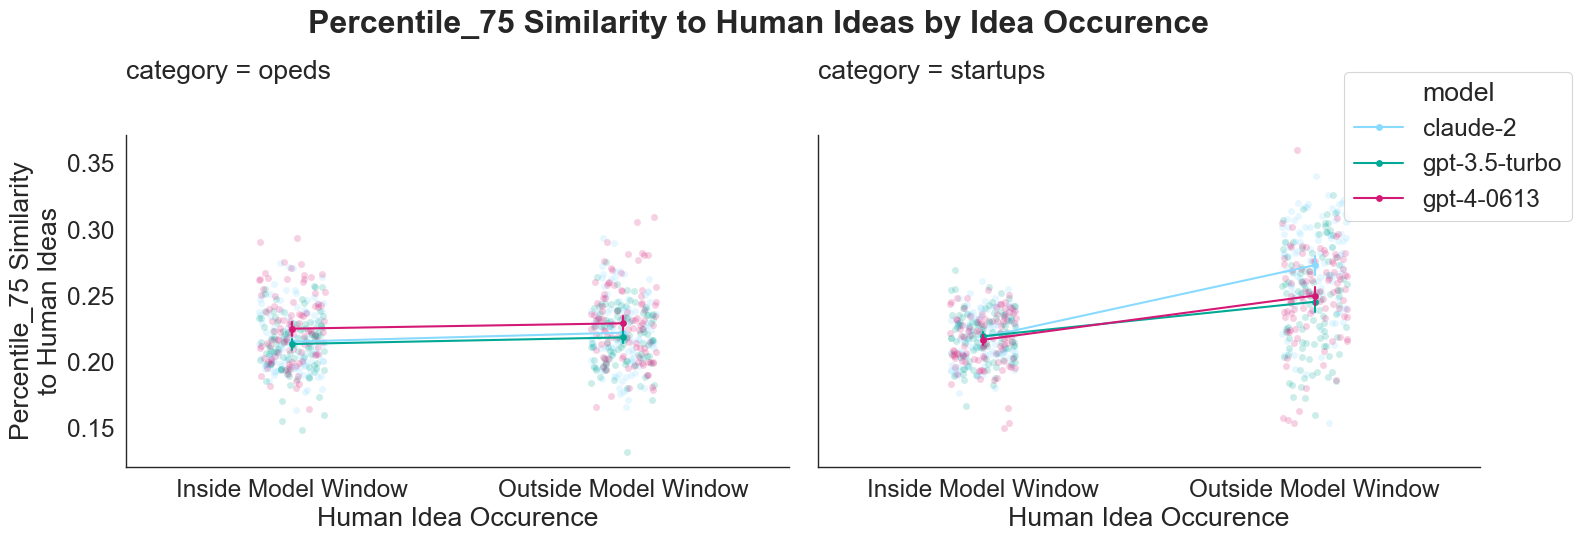

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

for dv in ['mean', 'median', 'percentile_75']:
    g = sns.FacetGrid(sample2, col='category', hue='model', col_wrap=2, height=5, aspect=1.5)
    g.map_dataframe(sns.pointplot, x='window_str', y=dv, markers='o', linestyles='-', dodge=True, linewidth=1.5)
    
    g.map_dataframe(sns.stripplot, x='window_str', y=dv, alpha=0.2, zorder=1)

    if g._legend:
        g._legend.remove()

    
    handles, labels = g.axes[0].get_legend_handles_labels()
    new_handles = [h for h in handles if isinstance(h, Line2D)]
    new_labels = labels[:len(new_handles)]
    

    g.fig.legend(handles=new_handles, labels=new_labels, title='model', loc='upper right', bbox_to_anchor=(1.05, 1))


    g.fig.subplots_adjust(top=0.85)  
    

    g.fig.suptitle(f"{dv.title()} Similarity to Human Ideas by Idea Occurence", fontweight='bold', y=1.1)
    
    g.set_axis_labels("Human Idea Occurence", f"{dv.title()} Similarity\nto Human Ideas")
    plt.savefig(f"{dv}_cat_plot.png", dpi=400)
    
    # Display the plot
    plt.show()


# Linear regression

In [72]:
import statsmodels.formula.api as smf
sample2['median2'] = sample2['median']*100
mod1 = smf.ols(formula='median2 ~ category*model*C(window_str)', data=sample2).fit()
display(mod1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                median2   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     30.96
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           6.73e-58
Time:                        16:45:24   Log-Likelihood:                -2630.5
No. Observations:                1200   AIC:                             5285.
Df Residuals:                    1188   BIC:                             5346.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            15.8501      0.218     72.792      0.000      15.423      16.277
category[T.startups]                                                                 -0.6151      0.308     -1.998      0.046      -1.219      -0.011
model[T.gpt-3.5-turbo]                                                               -0.1351      0.308     -0.439      0.661      -0.739       0.469
model[T.gpt-4-0613]                                                                   0.7618      0.308      2.474      0.014       0.158       1.366
C(window_str)[T.Outside Model Window]                                                 0.2621      0.308      0.851      0.395      -0.342       0.866
category[T.startups]:model[T.gpt-3.5-turbo]                                           0.4023      0.435      0.924      0.356      -0.452       1.257
category[T.startups]:model[T.gpt-4-0613]                                             -0.7325      0.435     -1.682      0.093      -1.587       0.122
category[T.startups]:C(window_str)[T.Outside Model Window]                            3.6077      0.435      8.284      0.000       2.753       4.462
model[T.gpt-3.5-turbo]:C(window_str)[T.Outside Model Window]                         -0.0611      0.435     -0.140      0.888      -0.916       0.793
model[T.gpt-4-0613]:C(window_str)[T.Outside Model Window]                            -0.1344      0.435     -0.309      0.758      -0.989       0.720
category[T.startups]:model[T.gpt-3.5-turbo]:C(window_str)[T.Outside Model Window]    -1.7219      0.616     -2.796      0.005      -2.930      -0.514
category[T.startups]:model[T.gpt-4-0613]:C(window_str)[T.Outside Model Window]       -0.9312      0.616     -1.512      0.131      -2.140       0.277
==============================================================================
Omnibus:                       24.755   Durbin-Watson:                   1.347
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.055
Skew:                          -0.157   Prob(JB):                     1.22e-09
Kurtosis:                       3.850   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
import marginaleffects

ames = {
    'model': marginaleffects.avg_comparisons(mod1, variables=['window_str'], by='model'), 
    'domain': marginaleffects.avg_comparisons(mod1, variables=['window_str'], by='category'), 
    'overall': marginaleffects.avg_comparisons(mod1, variables=['window_str'])

}



for (desc, data) in ames.items():
    data_df = data.to_pandas()
    data_df = data_df.query("term=='window_str'")
    ames[desc] = data_df

for (desc, data) in ames.items():
    print(desc)
    display(data.round(3))

model


,model,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,claude-2,window_str,mean(Outside Model Window) - mean(Inside Model...,2.066,0.218,9.488,0.0,inf,1.639,2.493
1,gpt-3.5-turbo,window_str,mean(Outside Model Window) - mean(Inside Model...,1.144,0.218,5.254,0.0,22.676,0.717,1.571
2,gpt-4-0613,window_str,mean(Outside Model Window) - mean(Inside Model...,1.466,0.218,6.732,0.0,35.803,1.039,1.893


domain


,category,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,opeds,window_str,mean(Outside Model Window) - mean(Inside Model...,0.197,0.178,1.108,0.268,1.9,-0.151,0.545
1,startups,window_str,mean(Outside Model Window) - mean(Inside Model...,2.920,0.178,16.426,0.000,inf,2.572,3.269


overall


,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
0,window_str,mean(Outside Model Window) - mean(Inside Model...,1.559,0.126,12.398,0.0,inf,1.312,1.805


# Bootstrap Max Sim (WIP)

The max is a better measure than the median but there are more ideas in the `in-window` period so that will confound results. One thing we can do is compare the probability that max sim occurs in `in-window` by downsampling `in-window` ideas. We can do this many times and arrive at a CI. 

In [330]:
import pandas as pd
from joblib import Parallel, delayed
import itertools

def min_unique_human_ids(df):
    counts = df.groupby(['category', 'in_window'])['human_id'].nunique().unstack(fill_value=0)
    counts['min_count'] = counts.min(axis=1)
    min_counts_dict = counts['min_count'].to_dict()
    return min_counts_dict

def compute_similarity_proportions(df, min_counts_dict, seed=None):
    # Sample human_ids uniformly across all categories and in_window statuses
    to_sample = {}
    for (category, in_window), group in df.groupby(['category', 'in_window']):
        unique_ids = group['human_id'].drop_duplicates()
        min_count = min(min_counts_dict[category], len(unique_ids))
        sampled_ids = unique_ids.sample(n=min_count, random_state=seed)
        to_sample[(category, in_window)] = set(sampled_ids)

    # Filter and calculate in a more efficient manner
    mask = df.apply(lambda x: x['human_id'] in to_sample[(x['category'], x['in_window'])], axis=1)
    df_sampled = df[mask]
    df_sampled.loc[:, 'max_sim_for_ai'] = df_sampled.groupby('ai_id')['sim'].transform('max')
    df_sampled.loc[:, 'is_max_sim'] = (df_sampled['sim'] == df_sampled['max_sim_for_ai']).astype(int)

    results = df_sampled.groupby(['model', 'category', 'in_window'])['is_max_sim'].sum().unstack().reset_index()

    # Normalize results and prepare output
    results['total'] = results[1] + results[0]
    results['in_window_prop'] = results[1] / results['total']
    results['out_window_prop'] = results[0] / results['total']
    results['seed'] = seed
    return results.to_dict(orient='records')


def run_multiple_simulations(df, N_iterations, N=20000):
    min_counts = min_unique_human_ids(df)

    seeds = [i for i in range(N_iterations)]
    # results = Parallel(n_jobs=-1)(
    #     delayed(compute_similarity_proportions)(df, min_counts, seed) for seed in seeds
    # )
    results = [compute_similarity_proportions(df, min_counts, seed) for seed in seeds]
    
    return results

N_iterations = 3  # Number of different simulations to run
results = run_multiple_simulations(df, N_iterations, N=2)
results = list(itertools.chain.from_iterable(results))


KeyboardInterrupt

